# Homework 02 - Analysis of yellow taxis' rides in New York city


In [1]:
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
import json
import folium
from branca.colormap import linear
import branca.colormap as cm
import seaborn as sns

## How to Clean Data
A fondamental step that is necessary to have more detailed and precise analysis is to clean up the initial given data. This means that in the millions of entries in the data we found a lot of weird values and we decided to cut them out from our analysis.

These are all the entries that have been deleted:
* Trips with a distance less or equal to zero. 
* The initial time of a trip must be strictly lower than the dropoff time.
* Total amount for a ride has to be greater ot at least equal to 3.3 dollars. This value is obtained from the (legend file)[http://www.nyc.gov/html/tlc/downloads/pdf/taxi_information.pdf] for taxis in New York, where is sated that there is an initial charge of 2.50 dollars plus 50 cent of State surcharge and 30 cent of improvement surcharge.
* There coulb be also errors with the dates. For this reason we heve controlled for each entry if the year is 2018 and that the month corresponds with the one that is being analyzed.
* We found some trips that has a long duration (i.e. more than 5 hours). We retained that a taxi trips can not be too long and for this reason we dropped all the trips longer than 3 hours.
* There were also very long rides, with houndres of miles as distance. We dropped all trips longer than 200 miles.
* The last thing that we dropped was the high rates for price over miles. We cut all the rates greater than 17.5 dollars per miles.

The initial data had size $53925735$ and the analyzed has size $52239189$.

The dropped lines are $1686546$ in total.

## RQ 1 - Taxi usage along the months

## RQ 2 - Taxi usage during a day

## RQ 3 - Duration of taxis' rides
This task has the aim to describe and illustrates the main characteristics of the duration of the trips during the first semester of 2018 in the whole City and to point out the differences between all the boroughs.  
In order to solve this problem we made some assumptions:
* In the borough part we have decided to keep in the plots the 'Unknown' borough. This has been decided because in the data the number of trips with this property is strongly significant. 

* All the analysis of trips duration is based on 4 different timeslot, that are: 

   1. Short trips: last in less or equal than 10 minutes.
   2. Medium-short trips: between 10 and 20 minutes.
   3. Medium-long trips: between 20 and 40 minutes.
   4. Long trips: last in more than 40 minutes.

In order to solve the task, there are three main steps to be computed:

   1. Retrieve data of the different from the files.
   2. Analysis of the whole Ney York
   3. Analysis through all the Boroughs


In [2]:
#global variables 
FMT = '%Y-%m-%d  %H:%M:%S'
data2 = pd.read_csv("taxi _zone_lookup.csv")
b = ['Manhattan', 'Queens', 'EWR', 'Bronx', 'Staten Island', 'Brooklyn', 'Unknown']
p1 = {}
p2 = {}
p3 = {}
p4 = {}

### Retrieve data of different months from the files.
In this first part we pass through all the data present in the different files.  
At the beginning it is necessary to initialize our variables loading the January file and cleaning up it (as it was described before). 

In [3]:
#initializing variables with JANUARY, whole NY

# retieving data to be cleaned
raw_data  = pd.read_csv("yellow_tripdata_2018-01.csv")

# cleaning data
raw_data['delta'] = (pd.to_datetime(raw_data['tpep_dropoff_datetime']) -  pd.to_datetime(raw_data['tpep_pickup_datetime'])).astype('timedelta64[m]')
data = raw_data.drop(raw_data[(raw_data.trip_distance >= 200) | (raw_data.delta > 180) |(raw_data.trip_distance <= 0) | (raw_data.tpep_dropoff_datetime <= raw_data.tpep_pickup_datetime) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).month != 1) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).year != 2018) | (raw_data.total_amount < 3.3) | ((raw_data.total_amount / raw_data.trip_distance) > 17.5)].index) 

# free memory deleting the raw_data
del raw_data

# taking only the columns that I need
data = data.loc[:, ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID']]

Due to division of trips duration into 4 timeslots, we have calculated that for each trip present in the dataset. 
The variable `delta` represents the duration, in minutes, of any single trip.

In [4]:
pickup_time = pd.to_datetime(data['tpep_pickup_datetime'].str.strip(), format = FMT)
dropoff_time = pd.to_datetime(data['tpep_dropoff_datetime'].str.strip(), format = FMT)
delta = (dropoff_time - pickup_time).astype('timedelta64[m]')

del pickup_time
del dropoff_time

In [5]:
#initializing variables with JANUARY, each Borough

borough = data.join(data2.set_index('LocationID'), on='PULocationID')

del data

for i in b:
    bor = borough[borough.Borough == i]
    pickup_time = pd.to_datetime(bor['tpep_pickup_datetime'].str.strip(), format = FMT)
    dropoff_time = pd.to_datetime(bor['tpep_dropoff_datetime'].str.strip(), format = FMT)
    delta_b = (dropoff_time - pickup_time).astype('timedelta64[m]')
    
    agg = pd.DataFrame(delta_b.value_counts(), columns = ['y'])
    agg = agg[agg.index >= 0]
    
    less_ten = agg[agg.index <= 10].sort_index()
    try:
        pr1 = (less_ten.cumsum() / delta.size).tail(1).y.item()
    except:
        pr1 = 0
    p1[i] = pr1 
    less_twenty = agg[agg.index <= 20]
    less_twenty = less_twenty[less_twenty.index > 10].sort_index()
    try:
        pr2 = (less_twenty.cumsum() / delta.size).tail(1).y.item()
    except:
        pr2 = 0
    p2[i] = pr2 
    more = agg[agg.index > 20]
    more = more[more.index <= 30].sort_index()
    try :
        pr3 = (more.cumsum() / delta.size).tail(1).y.item()
    except:
        pr3 = 0
    p3[i] = pr3 
    more_hour = agg[agg.index > 30].sort_index()
    try :
        pr4 = (more_hour.cumsum() / delta.size).tail(1).y.item()
    except:
        pr4 = 0
    p4[i] = pr4


The same procedure used in the initialization step with January is then applied to all the other months. 
At the end of this loop, for the whole city part, we saved the number of trips for all 1-minute timeslots.
Instead, for the boroughs part, we kept for each borough the average percentages of the 4 timeslots presented before.  

In [6]:
#retriving data in each month of 2018

for i in range(2,7):
        # retieving data to be cleaned
        raw_data  = pd.read_csv("yellow_tripdata_2018-0"+str(i)+".csv")

        # cleaning data
        raw_data['delta'] = (pd.to_datetime(raw_data['tpep_dropoff_datetime']) -  pd.to_datetime(raw_data['tpep_pickup_datetime'])).astype('timedelta64[m]')
        data = raw_data.drop(raw_data[(raw_data.trip_distance >= 200) | (raw_data.delta > 180) |(raw_data.trip_distance <= 0) | (raw_data.tpep_dropoff_datetime <= raw_data.tpep_pickup_datetime) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).month != i) | (pd.DatetimeIndex(raw_data['tpep_pickup_datetime']).year != 2018) | (raw_data.total_amount < 3.3) | ((raw_data.total_amount / raw_data.trip_distance) > 17.5)].index) 

        # free memory deleting the raw_data
        del raw_data

        # taking only the columns that I need
        data = data.loc[:, ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID']]
    
        pickup_time = pd.to_datetime(data['tpep_pickup_datetime'].str.strip(), format = FMT)
        dropoff_time = pd.to_datetime(data['tpep_dropoff_datetime'].str.strip(), format = FMT)
        delta = delta.append((dropoff_time - pickup_time).astype('timedelta64[m]'))
        del pickup_time
        del dropoff_time
        agg = pd.DataFrame(delta.value_counts(), columns = ['number_of_rides'])
        agg = agg[agg.index >= 0]
                
        borough = data.join(data2.set_index('LocationID'), on='PULocationID')
        del data
        
        #looking for timeslots data in each borough        
        for i in b:
            bor = borough[borough.Borough == i]
            pickup_time = pd.to_datetime(bor['tpep_pickup_datetime'].str.strip(), format = FMT)
            dropoff_time = pd.to_datetime(bor['tpep_dropoff_datetime'].str.strip(), format = FMT)
            delta_b = (dropoff_time - pickup_time).astype('timedelta64[m]')
    
            agg = pd.DataFrame(delta_b.value_counts(), columns = ['y'])
            agg = agg[agg.index >= 0]
    
            less_ten = agg[agg.index <= 10].sort_index()
            try:
                pr1 = (less_ten.cumsum() / delta_b.size).tail(1).y.item()
            except:
                pr1 = 0
            p1[i] = (p1[i] + pr1) /2
            less_twenty = agg[agg.index <= 20]
            less_twenty = less_twenty[less_twenty.index > 10].sort_index()
            try:
                pr2 = (less_twenty.cumsum() / delta_b.size).tail(1).y.item()
            except:
                pr2 = 0
            p2[i] = (p2[i] + pr2) /2
            more = agg[agg.index > 20]
            more = more[more.index <= 40].sort_index()
            try :
                pr3 = (more.cumsum() / delta_b.size).tail(1).y.item()
            except:
                pr3 = 0
            p3[i] = (p3[i] + pr3) /2
            more_hour = agg[agg.index > 40].sort_index()
            try :
                pr4 = (more_hour.cumsum() / delta_b.size).tail(1).y.item()
            except:
                pr4 = 0
            p4[i] = (p4[i] + pr4) /2
del data2

### Analysis of the whole Ney York


In this part, we illustrates through graphs the distribution of the trips duration through the City. 

The table shows the 1-minute timeslots and the related number of trips.

The first plot represents the distribution of the trips from 0 to 60 minutes. It can be seen that the highest number of rides last in the firts 10 minutes. The maximum is reached by the trip that last in 6 minutes. 
The graph also shows that the rides seem to exponentially decrease as longer they become.

[Text(0, 0.5, 'Number of trips'), Text(0.5, 0, 'Duration (minutes)')]

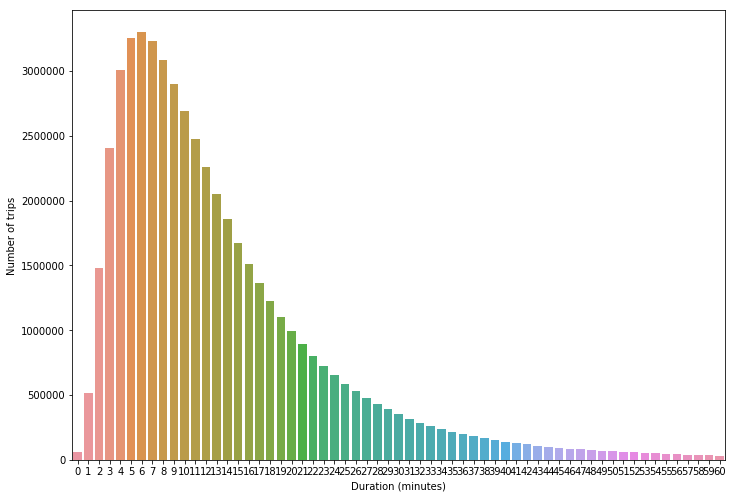

In [7]:
#creating the dataframe. Each column of the plot represents a 1-minute timeslot (ascending order)
agg = pd.DataFrame(delta.value_counts(), columns = ['number_of_rides'])
agg = agg[agg.index >= 0]
agg.index = agg.index.astype(int)
distro = agg[agg.index <= 60]
distro = distro.sort_index()

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.barplot(x = distro.index, y = 'number_of_rides', data=distro, )
ax.set(xlabel='Duration (minutes)', ylabel='Number of trips')


This code is used to divide the all the 1-minute timeslots into the 4 timeslots.

In [8]:
#rides that least less than 10 minutes
less_ten = agg[agg.index <= 10]
less_ten = less_ten.sort_index()
percent1 = (less_ten.cumsum() / delta.size).tail(1).number_of_rides.item()

#rides that least more than 10 minutes and less 20 minutes
less_twenty = agg[agg.index <= 20]
less_twenty = less_twenty[less_twenty.index > 10]
less_twenty = less_twenty.sort_index()
percent2 = (less_twenty.cumsum() / delta.size).tail(1).number_of_rides.item()

#rides that least more than 20 minutes and less than 40 minutes
more = agg[agg.index > 20]
more = more[more.index <= 40]
more = more.sort_index()
percent3 = (more.cumsum() / delta.size).tail(1).number_of_rides.item()

#rides that least more 40 minutes
more_hour = agg[agg.index > 40] 
more_hour = more_hour.sort_index()
percent4 = (more_hour.cumsum() / delta.size).tail(1).number_of_rides.item()

A relevant information about the distribution of the various durations can be seen thanks to the pie chart. 
Here is shown the contrast that is present between short and long rides. The half of all the trips is formed by the less-than-10-minutes trips. It is also highlited that the short and the medium-short rides are the 80% of the total. 

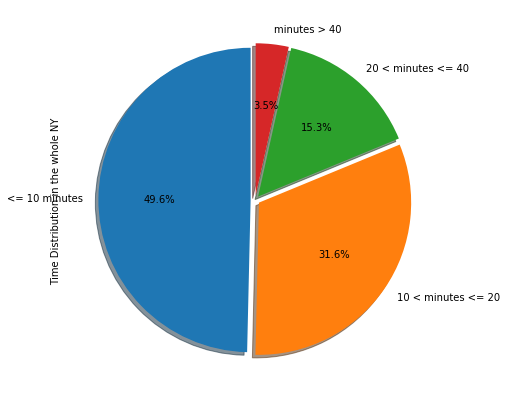

In [9]:
d = {'Time Distribution in the whole NY': [percent1, percent2, percent3, percent4]}
df = pd.DataFrame(data=d, index=['<= 10 minutes', '10 < minutes <= 20', '20 < minutes <= 40', 'minutes > 40'])
plt.figure(figsize=(7,7))
explode = (0.03, 0.03, 0.03, 0.03) 
df['Time Distribution in the whole NY'].plot.pie(autopct='%1.1f%%', explode = explode, startangle=90, shadow=True, legend = False, fontsize=10)

### Analysis through all the Boroughs
In this part we focused our attention in the differences present through the NY's boroughs.
First of all the table represented percentages-per-timeslots for each borough was created. 

In [10]:
# create dataframes from dictionaries with percentages for each boroughs
my1 = pd.DataFrame.from_dict(p1, orient='index', dtype=None, columns=['<= 10 min'])
my2 = pd.DataFrame.from_dict(p2, orient='index', dtype=None, columns=['10 < min <= 20'])
my3 = pd.DataFrame.from_dict(p3, orient='index', dtype=None, columns=['20 < min <= 40'])
my4 = pd.DataFrame.from_dict(p4, orient='index', dtype=None, columns=['min > 40'])

# joining the dataframes
result = pd.concat([my1, my2, my3], axis=1)
my4 = my4.reset_index(drop=True)
result = result.reset_index(drop=True)
result = result.join(my4)
result = result.rename(index={0: 'Manhattan', 1: 'Queens', 2: 'EWR', 3:'Bronx', 4: 'Staten Island', 5:'Brooklyn', 6:'Unknown'})

result

,<= 10 min,10 < min <= 20,20 < min <= 40,min > 40
Manhattan,0.506962,0.328164,0.141510,0.020596
Queens,0.092294,0.145545,0.401409,0.331365
EWR,0.570856,0.071056,0.155915,0.170924
Bronx,0.317644,0.278729,0.244007,0.128393
Staten Island,0.257170,0.142798,0.212865,0.355917
Brooklyn,0.401287,0.322911,0.199381,0.045526
Unknown,0.469813,0.308022,0.154013,0.037428


The following bar chart shows borough per bourough how the timeslots percentages differ. 
It can be seen that the percentages of the boroughs are diffent from what we said about the whole city. It seems that only Manhattan (and the Unknown one) reflects the proportion found before. 
In two boroughs, Queens and Staten Island, the short trips are not the highest percentage but, respectvively, the medium-long and the long trips.
In the EWR zones the short rides reach almost the 60%, that is almolst 10% more of the average of short trips in the whole City.  

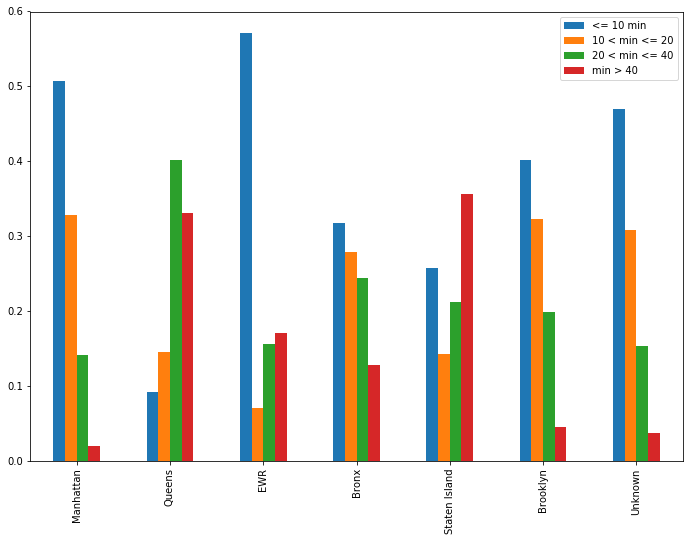

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = result.plot.bar(ax =ax)
ax

## RQ 4 - Most used payment method

## RQ 5 - Correlation between distance and duration of trips

## CRQ 1 -  Correlation between fare for mile and NY's borough

## CRQ 2 - Visualization of taxis' movements